In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import json
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data-in/'
DATA_OUT_PATH = './data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb')) # 이진데이터
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r')) # 아스키데이터

- 자연어 또한 CNN네트워크층을 적용 가능
- 출저 : Yoon Kim cnn : Convolutional Neural Networks for Sentence Classification

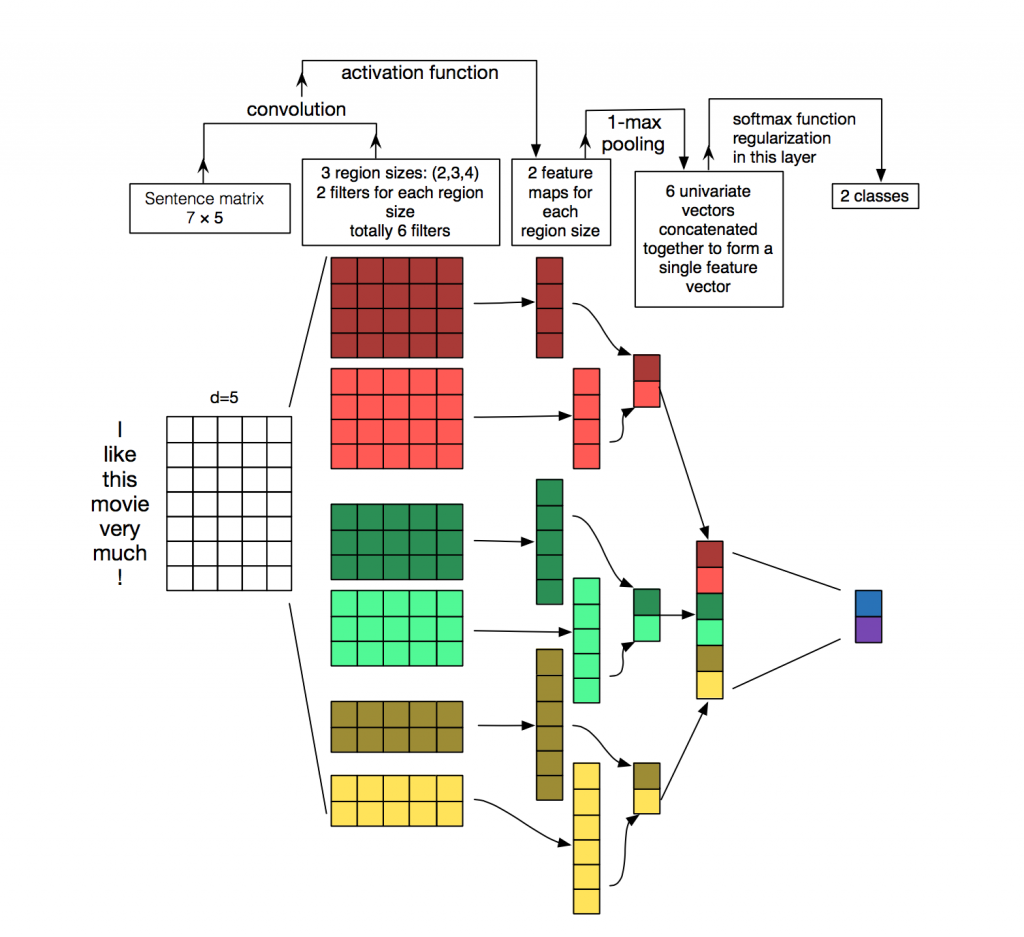

- 커널 사이즈는 이미지랑 다르게 문자는 1차원임

- 커널사이즈는 2개씩 2개, 3개씩 2개, 4개씩 2개 총 6개의 필터가 5차원으로 이루어짐

- 사이즈가 2개인 필터는 6행, 3개인 필터는 5행, 4개인 필터는 4행이 나옴

- 사이즈가 같은 필터마다 1-MaxPooling을 해줌 (가장 큰것을 1개 뽑아냄)

- 뽑아낸 것을 concatation으로 붙여줌

- 두개의 클래스 (긍정 / 부정) 으로 줄여줌

- 기본적으로 이 그림은 필터를 각각 따로 뽑아서 구성했기 때문에 models.Sequential을 사용할 수 없고 subclass를 사용해야한다

In [6]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {
    'model_name': model_name,
    'vocab_size': prepro_configs['vocab_size'],
    'embedding_size': 128,
    'num_filters': 100,
    'dropout_rate': 0.5,
    'hidden_dimension': 250,
    'output_dimension': 1
}

In [7]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        
        self.embedding = layers.Embedding(kargs['vocab_size'] + 1, 
                                          kargs['embedding_size'])
        
        # 여러개 존재하는 convolution층 구현
        self.conv_list = [
            layers.Conv1D(kargs['num_filters'], kernel_size=kernel_size, 
                         activation='relu',
                    # 커널 안의 값은 random하게 잡히면서 학습하는 가중치인데
                    # 최대 값을 3을 넘지 못하게 막아줌
                    kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
            for kernel_size in [3, 4, 5]
        ]
        
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                               activation=tf.keras.activations.relu,
                    kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation=tf.keras.activations.sigmoid,
                    kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [8]:
model = CNNClassifier(**kargs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# min_delta는 좋아졌다 안좋아졌다의 판단의 최소값을 지정
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,
                          patience=3)

# h5파일은 파라미터값만 저장하기때문에 모델이 있어야지만 파라미터를 불러올수있음
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
    
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', 
                                  verbose=1, save_best_only=True,
                                  save_weights_only=True)

In [11]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=VALID_SPLIT,
                   callbacks=[early_stop, model_checkpoint])

Epoch 1/10
263/264 [============================>.] - ETA: 0s - loss: 0.4591 - accuracy: 0.7768
Epoch 1: val_accuracy improved from -inf to 0.82120, saving model to ./data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 17s 59ms/step - loss: 0.4589 - accuracy: 0.7769 - val_loss: 0.3933 - val_accuracy: 0.8212
Epoch 2/10
263/264 [============================>.] - ETA: 0s - loss: 0.3512 - accuracy: 0.8459
Epoch 2: val_accuracy improved from 0.82120 to 0.82867, saving model to ./data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 15s 57ms/step - loss: 0.3512 - accuracy: 0.8459 - val_loss: 0.3858 - val_accuracy: 0.8287
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8734
Epoch 3: val_accuracy did not improve from 0.82867
264/264 [==============================] - 15s 56ms/step - loss: 0.2991 - accuracy: 0.8734 - val_loss: 0.3947 - val_accuracy: 0.8229
Epoch 4/10
263/264 [=====================

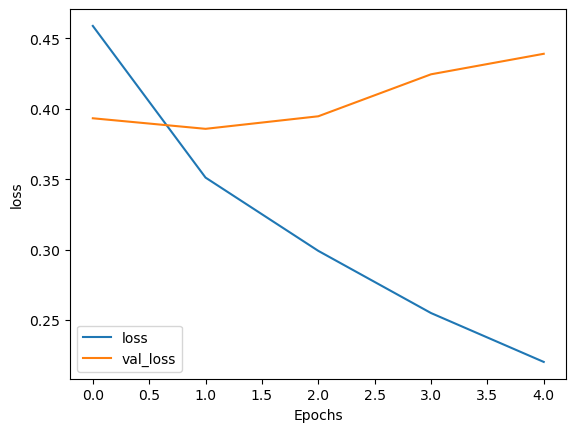

In [12]:
import matplotlib.pyplot as plt

plot_graphs(history, 'loss')

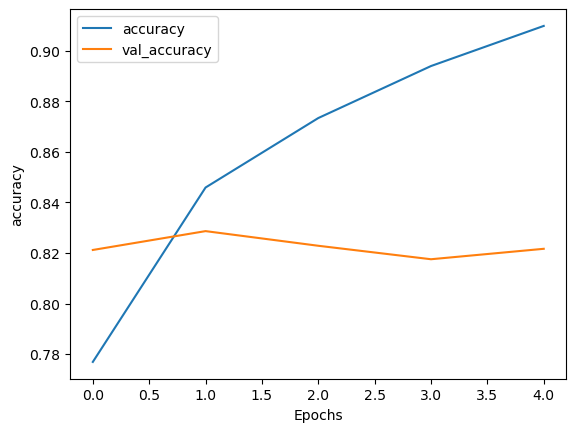

In [13]:
plot_graphs(history, 'accuracy')

In [14]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [15]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [16]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 2s 2ms/step - loss: 0.3866 - accuracy: 0.8268


[0.3866470754146576, 0.8267999887466431]